#Data Preperation

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


label_map = {
    "tetragonal": 0,
    "orthorhombic": 1,
    "trigonal": 2,
    "cubic": 3,
    "triclinic": 4,
    "monoclinic": 5,
    "hexagonal": 6
}

# 自定義 Dataset
class XRD_Dataset(Dataset):
    def __init__(self, file_list, data_dir):
        self.file_list = file_list
        self.data_dir = data_dir

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name, label = self.file_list[idx]

        # 將 .cif 檔名更改為 .npz
        file_name = file_name.replace('.cif', '_convolved.npz')

        file_path = os.path.join(self.data_dir, file_name)
        data = np.load(file_path)
        x = np.stack((data['x_fine'], data['y_convolved']), axis=1).astype(np.float32)
        # Map string label to integer index
        label = label_map[label]
        return x, label

# 讀取 csv 文件
csv_path = "/content/drive/MyDrive/xrd_training/structure_info.csv"  # 替換為實際 csv 文件路徑
!unzip /content/drive/MyDrive/xrd_training/output_data.zip
data_dir = "/content/output_data"  # 包含 .npz 文件的目錄
df = pd.read_csv(csv_path)



串流輸出內容已截斷至最後 5000 行。
  inflating: output_data/4000950_convolved.npz  
  inflating: output_data/2010029_convolved.npz  
  inflating: output_data/9005109_convolved.npz  
  inflating: output_data/9001581_convolved.npz  
  inflating: output_data/7204651_convolved.npz  
  inflating: output_data/9015097_convolved.npz  
  inflating: output_data/9017878_convolved.npz  
  inflating: output_data/2002958_convolved.npz  
  inflating: output_data/4336921_convolved.npz  
  inflating: output_data/4344119_convolved.npz  
  inflating: output_data/2106754_convolved.npz  
  inflating: output_data/1534953_convolved.npz  
  inflating: output_data/1530770_convolved.npz  
  inflating: output_data/2106604_convolved.npz  
  inflating: output_data/1532534_convolved.npz  
  inflating: output_data/1534803_convolved.npz  
  inflating: output_data/1524266_convolved.npz  
  inflating: output_data/1526022_convolved.npz  
  inflating: output_data/2002686_convolved.npz  
  inflating: output_data/4330033_convolved.npz  

**Note: If you've run the above cell once and it's not working on the second time, try to delete the \output_data and the \MACOSX directories.**

In [3]:
# 分割數據集

split_info = {
    "tetragonal": (3000, 500, 100),
    "orthorhombic": (3000, 500, 300),
    "trigonal": (1500, 500, 100),
    "cubic": (2000, 500, 100),
    "triclinic": (1800, 500, 100),
    "monoclinic": (3000, 500, 300),
    "hexagonal": (100, 10, 5)
}

def normalize_data(x):
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    return (x - mean) / (std + 1e-8)

class small_XRD_Dataset(Dataset):
    def __init__(self, file_list, data_dir):
        self.file_list = file_list
        self.data_dir = data_dir

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name, label = self.file_list[idx]

        # 將 .cif 檔名更改為 .npz
        file_name = file_name.replace('.cif', '_convolved.npz')

        file_path = os.path.join(self.data_dir, file_name)
        data = np.load(file_path)
        x = np.stack((data['x_fine'], data['y_convolved']), axis=1).astype(np.float32)
        # Map string label to integer index
        label = label_map[label]
        x = normalize_data(x);
        x = x[::2]
        return x, label

train_list, test_list, val_list = [], [], []

for label, (train_size, test_size, val_size) in split_info.items():
    files = df[df['cell_structure'] == label][['filename', 'cell_structure']].values.tolist()

    # 分割成訓練、測試、驗證集
    train_files, temp_files = train_test_split(files, train_size=train_size, random_state=42)
    test_files, temp_files = train_test_split(temp_files, train_size=test_size, random_state=42)
    val_files, temp_files = train_test_split(temp_files, train_size=val_size, random_state=42)

    train_list.extend(train_files)
    test_list.extend(test_files)
    val_list.extend(val_files)

# 創建 DataLoader
batch_size = 32

train_dataset = small_XRD_Dataset(train_list, data_dir)
test_dataset = small_XRD_Dataset(test_list, data_dir)
val_dataset = small_XRD_Dataset(val_list, data_dir)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("數據加載完成：")
print(f"訓練集樣本數: {len(train_dataset)}")
print(f"測試集樣本數: {len(test_dataset)}")
print(f"驗證集樣本數: {len(val_dataset)}")



數據加載完成：
訓練集樣本數: 14400
測試集樣本數: 3010
驗證集樣本數: 1005


In [4]:
print(f"Number of batches in train_loader: {len(train_loader)}")
for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    print(f"Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
    break  # Only for verification

Number of batches in train_loader: 450
Inputs shape: torch.Size([32, 4250, 2]), Labels shape: torch.Size([32])


#sCNN_BiLSTM

In [5]:
import torch
import torch.nn as nn

class Simplified_CNN_BiLSTM(nn.Module):
    def __init__(self, num_classes):
        super(Simplified_CNN_BiLSTM, self).__init__()
        # CNN 部分
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=32, kernel_size=5, padding=2)  # 輸入通道數 2
        self.pool = nn.MaxPool1d(kernel_size=2)  # 長度減半
        self.dropout = nn.Dropout(0.5)

        # LSTM 部分
        self.lstm = nn.LSTM(input_size=32, hidden_size=32, num_layers=1, batch_first=True, bidirectional=True)

        # 全連接層
        self.fc = nn.Linear(32 * 2, num_classes)  # BiLSTM 輸出雙向拼接

    def forward(self, x):
        # CNN
        x = torch.relu(self.conv1(x))  # [batch_size, 32, 4250]
        x = self.pool(x)  # [batch_size, 32, 2125]
        x = self.dropout(x)

        # LSTM
        x = x.permute(0, 2, 1)  # [batch_size, 32, 2125] -> [batch_size, 2125, 32]
        x, _ = self.lstm(x)  # [batch_size, 2125, 64]
        x = x[:, -1, :]  # 取最後一個時間步的輸出 [batch_size, 64]

        # 全連接層
        x = self.fc(x)  # [batch_size, num_classes]
        return x


In [6]:
import torch.nn.functional as F

def evaluate_epoch(model, data_loader, criterion):
    """
    評估模型在數據集上的表現，計算平均損失和準確率。

    Args:
    - model (nn.Module): 待評估的 PyTorch 模型。
    - data_loader (DataLoader): 驗證或測試集的數據加載器。
    - criterion (nn.Module): 損失函數。

    Returns:
    - avg_loss (float): 在數據集上的平均損失。
    - accuracy (float): 分類準確率 (0-1 範圍)。
    """
    model.eval()  # 設置模型為評估模式
    device = next(model.parameters()).device  # 獲取模型的設備
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # 關閉梯度計算以加速評估
        for inputs, labels in data_loader:
            # 將數據移動到設備（GPU 或 CPU）
            inputs, labels = inputs.to(device), labels.to(device)

            # Reshape to (batch_size, 1, num_features) to match model input
            inputs = inputs.permute(0, 2, 1)  # [batch_size, seq_len, channels]

            # 前向傳播
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 記錄損失
            total_loss += loss.item()

            # 計算準確率
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # 平均損失
    avg_loss = total_loss / len(data_loader)

    # 準確率
    accuracy = correct / total

    return avg_loss, accuracy

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        probs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=probs.size(1)).float()

        pt = torch.sum(targets_one_hot * probs, dim=1)
        log_pt = torch.log(pt)
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = -alpha_t * (1 - pt) ** self.gamma * log_pt
        else:
            loss = -(1 - pt) ** self.gamma * log_pt

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

##Training

**Note: choose your loss function here.**

In [7]:
# 定義類別數量（如晶系數量）
num_classes = 7

# 初始化模型
sim_model = Simplified_CNN_BiLSTM(num_classes=num_classes).to(device)
print(sim_model)

# 定義損失函數與優化器
# Choose your loss function here
# criterion = FocalLoss(gamma=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sim_model.parameters(), lr=0.001)
loss_list = []
val_acc_list = []

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# 訓練範例
def sim_train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1)  # [batch_size, seq_len, channels]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        loss_list.append(running_loss)
        val_loss,val_acc = evaluate_epoch(model, val_loader, criterion)
        val_acc_list.append(val_acc)
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")
        print(f"Epoch {epoch+1}/{num_epochs}, Acc on Val: {val_acc:.4f}")


Simplified_CNN_BiLSTM(
  (conv1): Conv1d(2, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(32, 32, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=64, out_features=7, bias=True)
)


In [8]:
epochs = 1
# 開始訓練
sim_train_model(sim_model, train_loader, criterion, optimizer, num_epochs=epochs)

Epoch 1/1, Loss: 1.7971
Epoch 1/1, Acc on Val: 0.3025


##Evaluation

In [9]:
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1)  # [batch_size, seq_len, channels]

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

In [10]:
evaluate_model(sim_model, test_loader)

Accuracy: 16.68%


16.677740863787374

In [11]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(loss_list, val_acc, num_epochs):
    """
    繪製訓練損失和驗證準確率在同一張圖上。

    Args:
    - loss_list (list): 訓練損失值列表。
    - val_acc (list): 驗證準確率值列表。
    - num_epochs (int): 總訓練 epoch 數。
    """
    epochs = range(1, num_epochs + 1)  # x 軸的 epoch 列表

    # 創建圖表
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # 左軸：訓練損失
    ax1.plot(epochs, loss_list, 'b-', label='Train Loss')  # 藍色線條
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params(axis='y', labelcolor='b')  # Y 軸使用藍色標籤

    # 右軸：驗證準確率
    ax2 = ax1.twinx()  # 創建共享 x 軸的新 y 軸
    ax2.plot(epochs, val_acc, 'r-', label='Validation Accuracy')  # 紅色線條
    ax2.set_ylabel('Accuracy', color='r')
    ax2.tick_params(axis='y', labelcolor='r')  # Y 軸使用紅色標籤

    # 加入圖例
    fig.tight_layout()  # 自動調整布局
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # 顯示圖表
    plt.title('Training Loss and Validation Accuracy')
    plt.show()

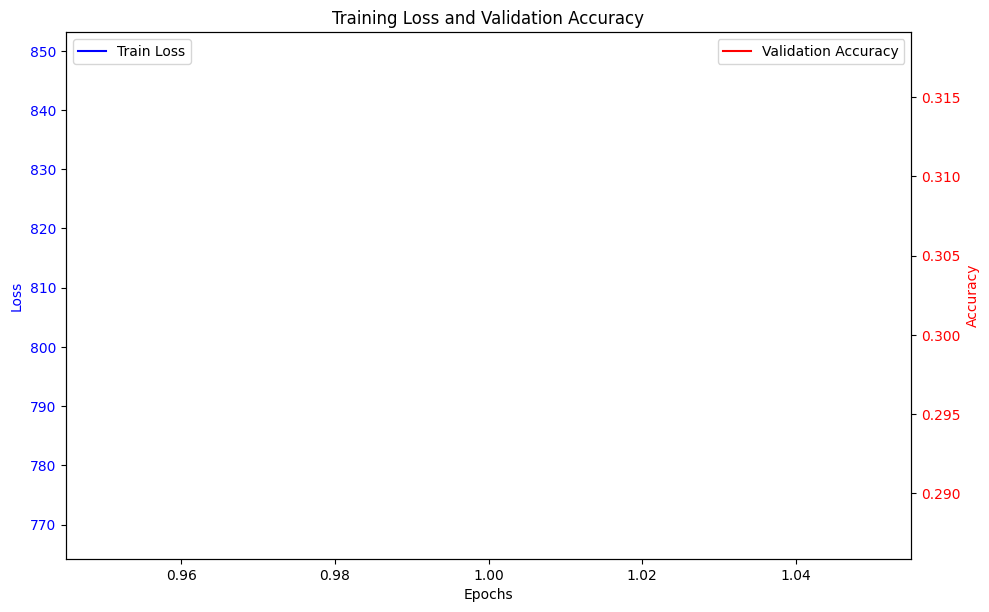

In [12]:
plot_loss_and_accuracy(loss_list, val_acc_list, epochs)

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

def evaluate_and_plot_confusion_matrix(model, data_loader, label_map, sample_percentage=0.5, seed=42):
    """
    Evaluates the model on a random sample of the data and plots a confusion matrix with percentage accuracies.

    Parameters:
    - model: The PyTorch model to evaluate.
    - data_loader: A DataLoader providing input data and labels.
    - label_map: A dictionary mapping class names to indices.
    - sample_percentage: The percentage of data to sample randomly for evaluation (default 50%).
    - seed: Random seed for reproducibility (default 42).

    Returns:
    - confusion_matrix_percent: A confusion matrix with percentage accuracies.
    """
    # Ensure GPU usage if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model = model.to(device)

    # Initialize confusion matrix
    num_classes = len(label_map)
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

    # Set random seed for reproducibility
    random.seed(seed)

    # Select a random subset of the data_loader (sample_percentage)
    total_samples = len(data_loader.dataset)
    num_samples_to_select = int(total_samples * sample_percentage)
    indices = random.sample(range(total_samples), num_samples_to_select)

    # Create a new DataLoader with the sampled indices
    sampled_data = torch.utils.data.Subset(data_loader.dataset, indices)
    sampled_loader = torch.utils.data.DataLoader(sampled_data, batch_size=data_loader.batch_size, shuffle=False)

    # Evaluate the model on the sampled data
    with torch.no_grad():
        for inputs, labels in sampled_loader:
            # Move data to the same device as the model
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1)  # (batch_size, 8500, 2) -> (batch_size, 2, 8500)

            # Perform forward pass
            outputs = model(inputs)  # Outputs shape: [batch_size, num_classes]
            _, predicted = torch.max(outputs, 1)

            # Update confusion matrix
            for label, pred in zip(labels, predicted):
                confusion_matrix[label.item(), pred.item()] += 1

    # Calculate percentage accuracies for each row (true class)
    confusion_matrix_percent = np.zeros_like(confusion_matrix, dtype=np.float32)

    for i in range(num_classes):
        total = confusion_matrix[i].sum()
        if total > 0:
            confusion_matrix_percent[i] = 100 * confusion_matrix[i] / total

    # Plot the confusion matrix as a heatmap
    class_names = list(label_map.keys())
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix_percent, annot=True, fmt=".1f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names, cbar=True)
    plt.title("Confusion Matrix (Percentage Accuracy)", fontsize=16)
    plt.xlabel("Predicted Class", fontsize=14)
    plt.ylabel("True Class", fontsize=14)
    plt.show()

    return confusion_matrix_percent


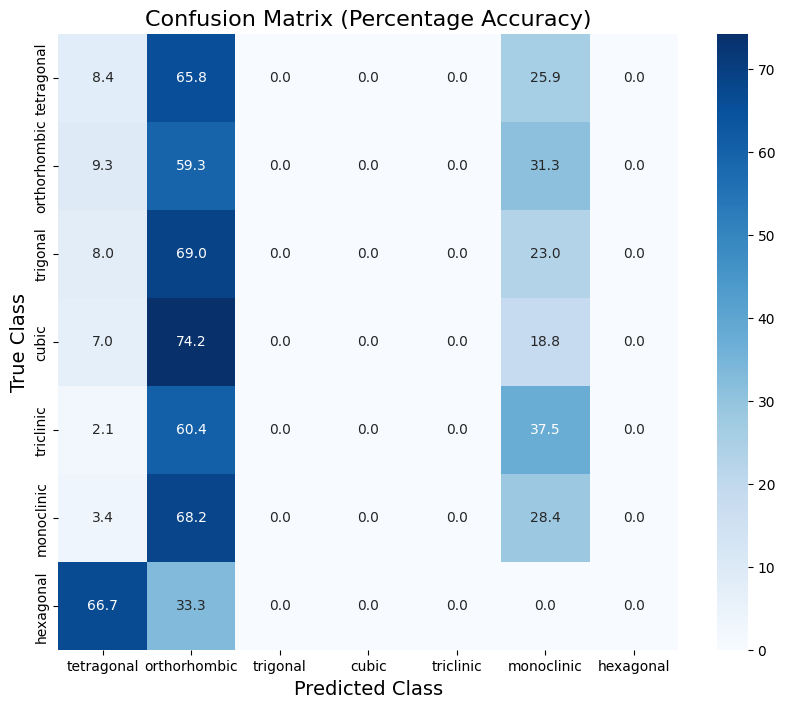

In [14]:
confusion_matrix_percent = evaluate_and_plot_confusion_matrix(sim_model, test_loader, label_map)

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

def extract_features_from_simplified_model(model, dataloader, device):
    model.eval()  # 設定為推論模式
    all_features = []
    all_labels = []

    with torch.no_grad():  # 停止梯度計算
        for inputs, labels in dataloader:
            # 確保數據與設備匹配
            inputs = inputs.permute(0, 2, 1).to(device)  # [batch_size, seq_len, channels]
            labels = labels.to(device)

            # 特徵提取過程
            x = torch.relu(model.conv1(inputs))  # 第一層卷積
            x = model.pool(x)
            # x = torch.relu(model.conv2(x))  # This line is removed as there is no conv2 in Simplified_CNN_BiLSTM
            # x = model.pool(x) # This line is removed as it was intended for conv2
            x = model.dropout(x)  # 卷積模塊的輸出

            # 如果需要提取 LSTM 特徵
            x = x.permute(0, 2, 1)  # 調整維度給 LSTM
            x, _ = model.lstm(x)  # BiLSTM 層輸出
            features = x[:, -1, :]  # 取最後一個時間步的輸出

            all_features.append(features.cpu().numpy())  # 將特徵移至 CPU 並轉為 numpy 格式
            all_labels.append(labels.cpu().numpy())  # 將標籤移至 CPU 並轉為 numpy 格式

    # 將所有 batch 特徵與標籤拼接
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_features, all_labels


def apply_tsne_and_visualize(features, labels):
    # Perform t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features)

    # Encode labels to numerical values for coloring
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    # Plot the t-SNE visualization
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=encoded_labels, cmap='viridis', s=10)
    plt.colorbar(scatter, label='Class Label')
    plt.title('t-SNE Visualization of XRD CNN Features')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

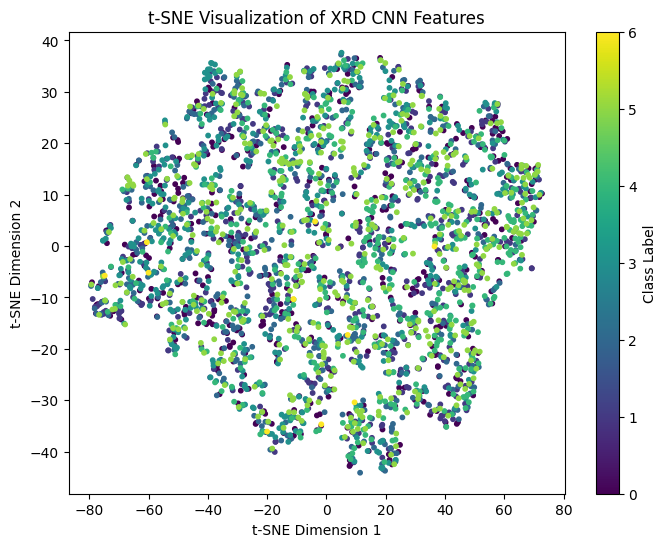

In [16]:
features, labels = extract_features_from_simplified_model(sim_model, test_loader, device)
apply_tsne_and_visualize(features, labels)

In [17]:
import matplotlib.pyplot as plt

def plot_certainty_histogram(model, dataloader, device):
    model.eval()  # 設定模型為推論模式
    correct_certainties = []
    incorrect_certainties = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1)  # [batch_size, seq_len, channels]

            outputs = model(inputs)

            # 計算 softmax 確定性
            probabilities = torch.softmax(outputs, dim=1)
            max_probs, predictions = torch.max(probabilities, dim=1)  # 取最大概率值和對應預測標籤

            # 將確定性分到正確和錯誤兩類
            correct_mask = predictions == labels
            incorrect_mask = ~correct_mask

            correct_certainties.extend(max_probs[correct_mask].cpu().numpy())  # 移動到 CPU 並轉為 NumPy 陣列
            incorrect_certainties.extend(max_probs[incorrect_mask].cpu().numpy())

    # 繪製正確與錯誤分類的直方圖
    plt.figure(figsize=(12, 6))

    # 正確分類
    plt.hist(correct_certainties, bins=20, color='green', alpha=0.7, label='Correct')
    # 錯誤分類
    plt.hist(incorrect_certainties, bins=20, color='red', alpha=0.7, label='Incorrect')

    plt.title('Network Certainty Histogram: Correct vs Incorrect')
    plt.xlabel('Certainty (Max Softmax Probability)')
    plt.ylabel('Number of Samples')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


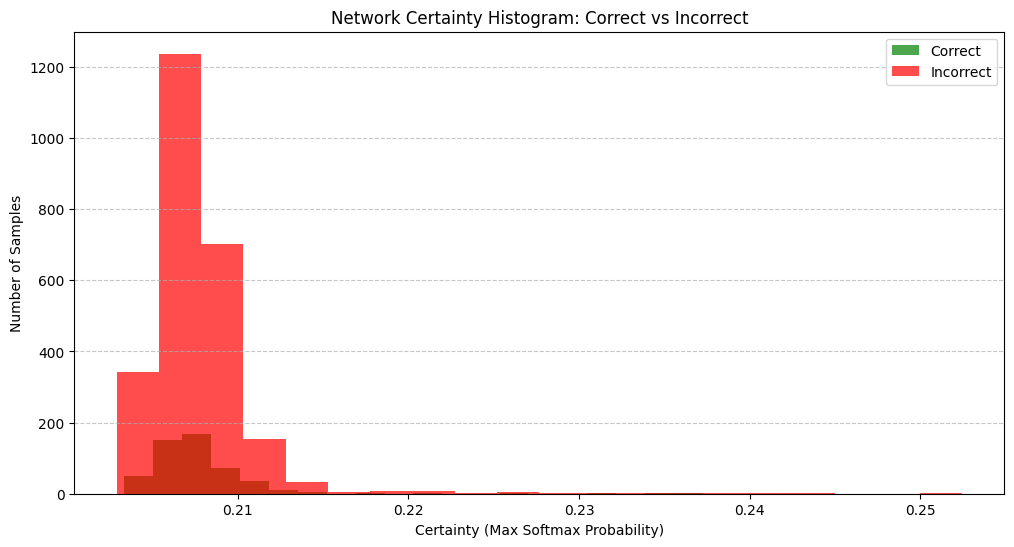

In [18]:
plot_certainty_histogram(sim_model, test_loader, device)

In [19]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader, Dataset
from scipy.signal import find_peaks
import os

# 確保模型處於推論模式
def calculate_certainties(model, dataloader, device):
    """
    計算模型的 certainty
    """
    certainties = []
    model.eval()
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)  # 將數據移動到設備上
            inputs = inputs.permute(0, 2, 1)
            outputs = model(inputs)  # 模型輸出
            probabilities = torch.softmax(outputs, dim=1)  # 計算 softmax 概率
            max_probs, _ = torch.max(probabilities, dim=1)  # 最大概率作為 certainty
            certainties.extend(max_probs.cpu().numpy())  # 移動到 CPU 並轉為 NumPy
    return np.array(certainties)

def extract_features_from_loader(loader):
    """
    從 dataloader 提取特徵 (y_convolved) 並合併為整個數據集。
    """
    features = []
    for inputs, _ in loader:
        batch_features = inputs[:, :, 1].numpy()  # 提取 y_convolved 作為特徵
        features.append(batch_features)
    return np.vstack(features)

def plot_full_data_correlation(features, certainties):
    """
    計算每個數據點與模型 certainty 的相關性並繪製 heatmap。
    """
    num_points = features.shape[1]  # 特徵維度數量（數據點數）
    correlation = []

    # 計算每個數據點與 certainty 的相關性
    for i in range(num_points):
        correlation.append(np.corrcoef(features[:, i], certainties)[0, 1])

    # 繪製相關性 heatmap
    plt.figure(figsize=(12, 6))
    # Use sns.heatmap to create the heatmap and assign it to a variable
    ax = sns.heatmap(np.array(correlation).reshape(1, -1), annot=False, cmap="viridis",
                xticklabels=100 if num_points <= 100 else False,  # 限制 x 軸標籤
                yticklabels=["Certainty"])

    # Add the colorbar using the heatmap object (ax)
    # plt.colorbar(ax=ax, label="Correlation Coefficient")

    plt.title("Full Data Correlation with Certainty")
    plt.xlabel("Data Point Index")
    plt.ylabel("Correlation")
    plt.show() # Moved plt.show() to the end


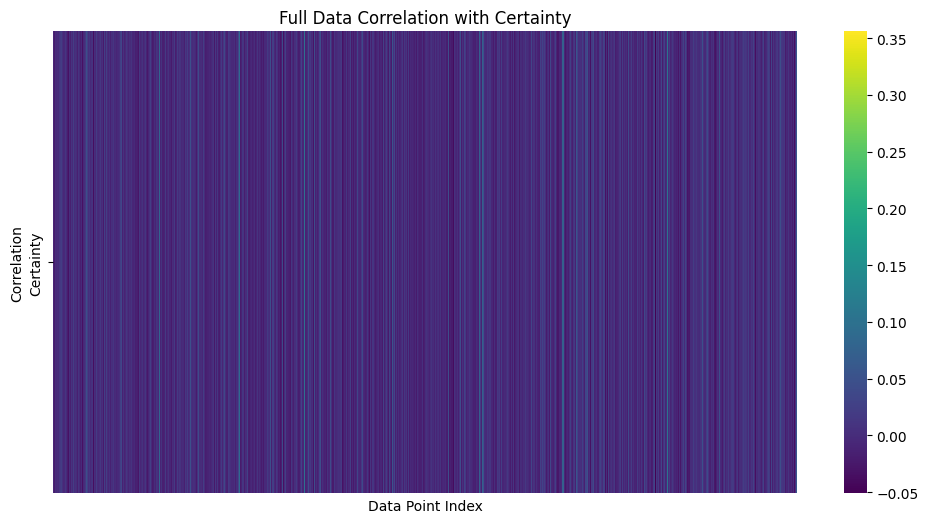

In [20]:
# 計算 Certainties
certainties = calculate_certainties(sim_model, test_loader, device)

# 提取特徵 (y_convolved)
features = extract_features_from_loader(test_loader)

# 確保長度匹配
assert features.shape[0] == len(certainties), "Mismatch between features and certainties!"

# 繪製全數據點的 heatmap
plot_full_data_correlation(features, certainties)